<a href="https://colab.research.google.com/github/SanthoshBV07/NLP_Bootcamp/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

In [6]:
df = pd.read_csv('/content/yelp_reviews_subset_2.csv')
print(df.head())

   Unnamed: 0                                               Text  Labels
0           0  My expectations for McDonalds are t rarely hig...       0
1           1  I've tried to give this McDonalds a chance but...       0
2           2  This McDonald's is so bad it's amazing.  \n\nO...       0
3           3  We had the worst possible experience at the Ea...       0
4           4  They burned my fish and they burned it bad.  O...       2


/tmp/ipython-input-586133965.py:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


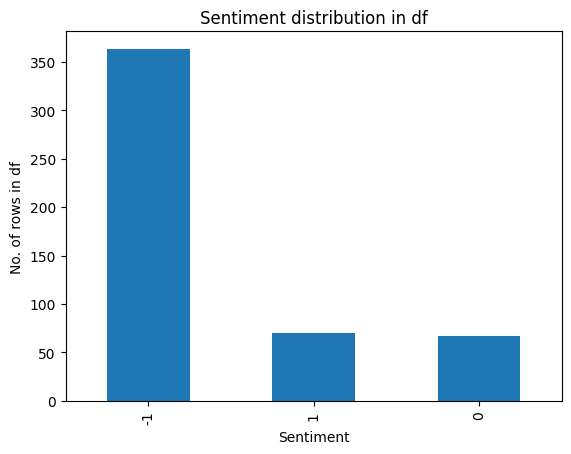

In [7]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1


# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['Labels']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [12]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
df['tokenized_text'] = [word_tokenize(x) for x in df['Text']]
print(df['tokenized_text'].head(10))

ps = PorterStemmer()
df['stemmed_tokens'] = [[ps.stem(y) for y in x] for x in df['tokenized_text']]
print(df['stemmed_tokens'].head(10))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    [My, expectations, for, McDonalds, are, t, rar...
1    [I, 've, tried, to, give, this, McDonalds, a, ...
2    [This, McDonald, 's, is, so, bad, it, 's, amaz...
3    [We, had, the, worst, possible, experience, at...
4    [They, burned, my, fish, and, they, burned, it...
5    [Some, how, even, though, the, food, at, this,...
6    [Mmm, ..., peppermint, mocha\n\nIn, my, quest,...
7    [If, there, was, ever, a, \, '', get, your, co...
8    [I, just, realized, they, remodeled, this, one...
9    [Great, location, !, Close, to, shops, and, th...
Name: tokenized_text, dtype: object
0    [my, expect, for, mcdonald, are, t, rare, high...
1    [i, 've, tri, to, give, thi, mcdonald, a, chan...
2    [thi, mcdonald, 's, is, so, bad, it, 's, amaz,...
3    [we, had, the, worst, possibl, experi, at, the...
4    [they, burn, my, fish, and, they, burn, it, ba...
5    [some, how, even, though, the, food, at, thi, ...
6    [mmm, ..., peppermint, mocha\n\nin, my, quest,...
7    [if, there, wa, ever, a,

In [13]:
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]],
                                                        df['sentiment'],
                                                        shuffle=shuffle_state,
                                                        test_size=test_size,
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
-1    255
 1     49
 0     46
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
-1    108
 1     21
 0     21
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               Text  Labels  \
0    139  The food is standard American fare--a bit over...       1   
1    129  I'm not much of a beer drinker, but my fiancee...       3   
2    258  ok so i've eaten here more than once but just ...       1   
3    227  Food was ok had a steak w/ shrimp side Ass mas...       1   
4     60  He was incredibly sexist/homophobic. He could ...       0   

                                      tokenized_text  \
0  [The, food, is, standard, American, fare, --, ...   
1  [I, 'm, not, much, of, a, beer, drinker, ,, bu...   
2  [ok, so, i, 've, eaten, here, more, than, once...   
3  [Food, was, ok, had, a, steak, w/, shrimp, sid...   
4  [He, was, incredi

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [28]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0):
        super(FeedforwardNeuralNetModel, self).__init__()

        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)

        return out

In [20]:
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(df, padding=False)

Dictionary without padding


In [21]:
VOCAB_SIZE = 30056
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [24]:
VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim,0)
ff_nn_bow_model =ff_nn_bow_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=0.001)

In [26]:
# Open the file for writing loss
ffnn_loss_file_name = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():

        optimizer.zero_grad()


        bow_vec = make_bow_vector(review_dict,row[4])


        probs = ff_nn_bow_model.forward(bow_vec)


        target = make_target(Y_train['sentiment'][index])


        loss = loss_function(probs, target)


        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

/tmp/ipython-input-1301629746.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bow_vec = make_bow_vector(review_dict,row[4])# Replace None with the correct code


Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


              precision    recall  f1-score   support

           0       0.80      0.90      0.84       108
           1       0.38      0.14      0.21        21
           2       0.40      0.38      0.39        21

    accuracy                           0.72       150
   macro avg       0.52      0.47      0.48       150
weighted avg       0.68      0.72      0.69       150

100
Index(['iter', ' loss'], dtype='object')


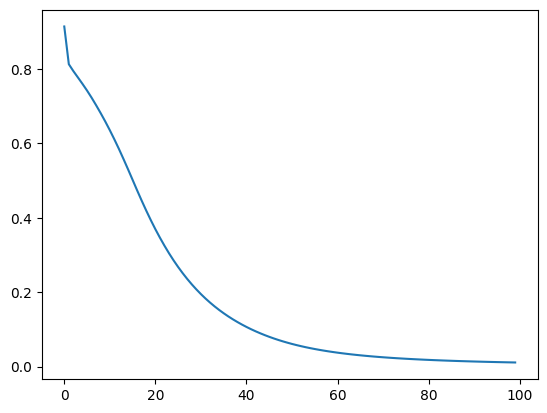

In [27]:
bow_ff_nn_predictions = []
original_lables_ff_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_500_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_500_padding_100_epochs.get_figure()
fig.savefig("ffnn_bow_loss_500_padding_100_epochs_less_lr.jpg")

In [30]:
# Initialize the Feedforward Neural Network model with dropout

ff_nn_bow_model_dropout = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim,0.4)
ff_nn_bow_model_dropout.to(device)


loss_function_dropout = nn.CrossEntropyLoss()  # Replace None with appropriate loss function
optimizer_dropout = optim.SGD(ff_nn_bow_model_dropout.parameters(), lr=0.001)  # Replace None with optimizer

# TODO: Prepare to record training loss
ffnn_loss_file_name_dropout = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr_dropout.csv'
f_dropout = open(ffnn_loss_file_name_dropout, 'w')
f_dropout.write('iter, loss\n')
losses_dropout = []
iter_dropout = 0

# Train the model
ff_nn_bow_model_dropout.train()
for epoch in range(num_epochs):
    if (epoch + 1) % 25 == 0:
        print(f"Epoch completed: {epoch + 1}")

    train_loss_dropout = 0


    for index, row in X_train.iterrows():
        optimizer_dropout.zero_grad()


        bow_vec = make_bow_vector(review_dict,row[4])


        logit = ff_nn_bow_model_dropout.forward(bow_vec)


        target = make_target(Y_train['sentiment'][index])


        loss = loss_function_dropout(logit, target)
        train_loss_dropout += loss.item()


        loss.backward()
        optimizer_dropout.step()

    # Log average loss for the epoch
    f_dropout.write(f"{epoch + 1},{train_loss_dropout / len(X_train)}\n")
    train_loss_dropout = 0

f_dropout.close()


/tmp/ipython-input-1156610660.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bow_vec = make_bow_vector(review_dict,row[4])


Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


Classification Report with Dropout:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       108
           1       0.36      0.19      0.25        21
           2       0.38      0.38      0.38        21

    accuracy                           0.71       150
   macro avg       0.52      0.48      0.49       150
weighted avg       0.68      0.71      0.69       150



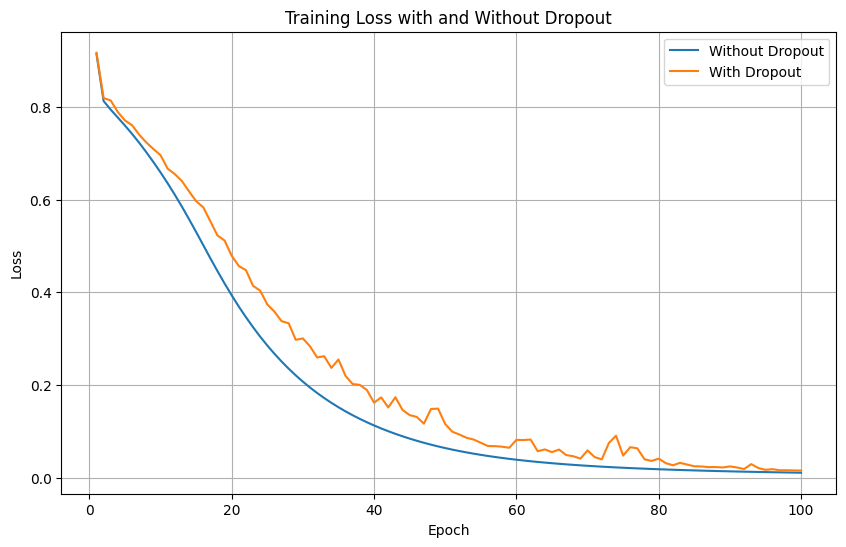

In [31]:
bow_ff_nn_predictions_dropout = []
original_lables_ff_bow_dropout = []

ff_nn_bow_model_dropout.eval() # Set model to evaluation mode
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        bow_ff_nn_predictions_dropout.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_dropout.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print("Classification Report with Dropout:")
print(classification_report(original_lables_ff_bow_dropout, bow_ff_nn_predictions_dropout))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df_dropout = pd.read_csv(ffnn_loss_file_name_dropout)

plt.figure(figsize=(10, 6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'], label='Without Dropout')
plt.plot(ffnn_loss_df_dropout['iter'], ffnn_loss_df_dropout[' loss'], label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with and Without Dropout')
plt.legend()
plt.grid(True)
plt.savefig("ffnn_bow_loss_comparison_dropout.jpg")
plt.show()